In [2]:
#import statements
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mne.io import read_raw_edf
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import layers
from keras import Sequential

In [3]:
#read in and preprocess data
data = read_raw_edf('sleep-cassette/SC4001E0-PSG.edf')
raw_data = data.get_data()
eeg_cz = raw_data[0]
eeg_cz = eeg_cz.reshape((eeg_cz.shape[0],1))
eeg_oz = raw_data[1]
eeg_oz = eeg_oz.reshape((eeg_cz.shape[0],1))
eog = raw_data[2]
#only care about eeg_cz, eeg_oz, eog
eog = eog.reshape((eeg_cz.shape[0],1))
X = np.concatenate((eeg_cz, eeg_oz, eog), axis = 1)
#normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

Extracting EDF parameters from C:\Users\Tyler\Documents\CSCI 5622 Final Project\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
#create sequence data for forward prediction
def forward_split_sequences_multivariate(data, seq_len, forecast_len):
    n = data.shape[0]
    x_data = []
    y_data = []
    for i in range(n - seq_len - forecast_len):
        x_data.append(data[i:i + seq_len])
        y_data.append(data[i + seq_len:i + seq_len + forecast_len])
    x = np.array(x_data)
    y = np.array(y_data)

    return x, y

#create sequence data for forward and back predicition
def bimodal_split_sequences_multivariate(data, seq_len, forecast_len):
    n = data.shape[0]
    x_data = []
    y_data = []
    for i in range(n - seq_len - forecast_len - seq_len):
        x_data.append(np.concatenate((data[i:i + seq_len], data[i + seq_len + forecast_len:i + seq_len + forecast_len + seq_len]), axis = 1))
        y_data.append(data[i + seq_len:i + seq_len + forecast_len])
    x = np.array(x_data)
    y = np.array(y_data)

    return x, y

In [5]:
#choose sequence length and forecast length
seq_len = 20
forecast_len = 10 

x, y = bimodal_split_sequences_multivariate(X, seq_len, forecast_len)

x_train = x
y_train = y

n_features_x = x_train.shape[2]
n_features_y = y_train.shape[2]

In [6]:
#build the model
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(32, input_shape = (seq_len,n_features_x))))
model.add(layers.Dense(forecast_len*n_features_y))
model.add(layers.Reshape([forecast_len, n_features_y]))
model.compile(optimizer = 'adam', loss = 'mse')

#save checkpoints
checkpoint_path = "checkpoints_forward_and_back/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, verbose = 1)

In [6]:
#fit model
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, callbacks = [cp_callback])

Epoch 1/10
248431/248436 [============================>.] - ETA: 0s - loss: 0.1685
Epoch 1: saving model to checkpoints_forward_and_back\cp-0001.ckpt
248436/248436 [==============================] - 1707s 7ms/step - loss: 0.1685
Epoch 2/10
248436/248436 [==============================] - ETA: 0s - loss: 0.1623
Epoch 2: saving model to checkpoints_forward_and_back\cp-0002.ckpt
248436/248436 [==============================] - 1639s 7ms/step - loss: 0.1623
Epoch 3/10
248436/248436 [==============================] - ETA: 0s - loss: 0.1612
Epoch 3: saving model to checkpoints_forward_and_back\cp-0003.ckpt
248436/248436 [==============================] - 1668s 7ms/step - loss: 0.1612
Epoch 4/10
248435/248436 [============================>.] - ETA: 0s - loss: 0.1611
Epoch 4: saving model to checkpoints_forward_and_back\cp-0004.ckpt
248436/248436 [==============================] - 1696s 7ms/step - loss: 0.1611
Epoch 5/10
248435/248436 [============================>.] - ETA: 0s - loss: 0.1607
E

In [7]:
#load best checkpoint
model.load_weights("checkpoints_forward_and_back/cp-0006.ckpt")

In [8]:
#read in and preprocess test data
test_data = read_raw_edf('sleep-cassette/SC4002E0-PSG.edf')
raw_test_data = test_data.get_data()
eeg_cz_test = raw_test_data[0]
eeg_cz_test = eeg_cz_test.reshape((eeg_cz_test.shape[0],1))
eeg_oz_test = raw_test_data[1]
eeg_oz_test = eeg_oz_test.reshape((eeg_cz_test.shape[0],1))
eog_test = raw_test_data[2]
eog_test = eog_test.reshape((eeg_cz_test.shape[0],1))
X_test = np.concatenate((eeg_cz_test, eeg_oz_test, eog_test), axis = 1)
X_test = scaler.transform(X_test)

Extracting EDF parameters from C:\Users\Tyler\Documents\CSCI 5622 Final Project\sleep-cassette\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [9]:
#process test data
seq_len = 20
forecast_len = 10 

x_test, y_test = bimodal_split_sequences_multivariate(X_test, seq_len, forecast_len)

(8489950, 20, 6) (8489950, 10, 3)


In [9]:
#evaluate model
test_mse = model.evaluate(x_test, y_test)

265311/265311 [==============================] - 1131s 4ms/step - loss: 0.2382


1/1 [==============================] - 0s 21ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

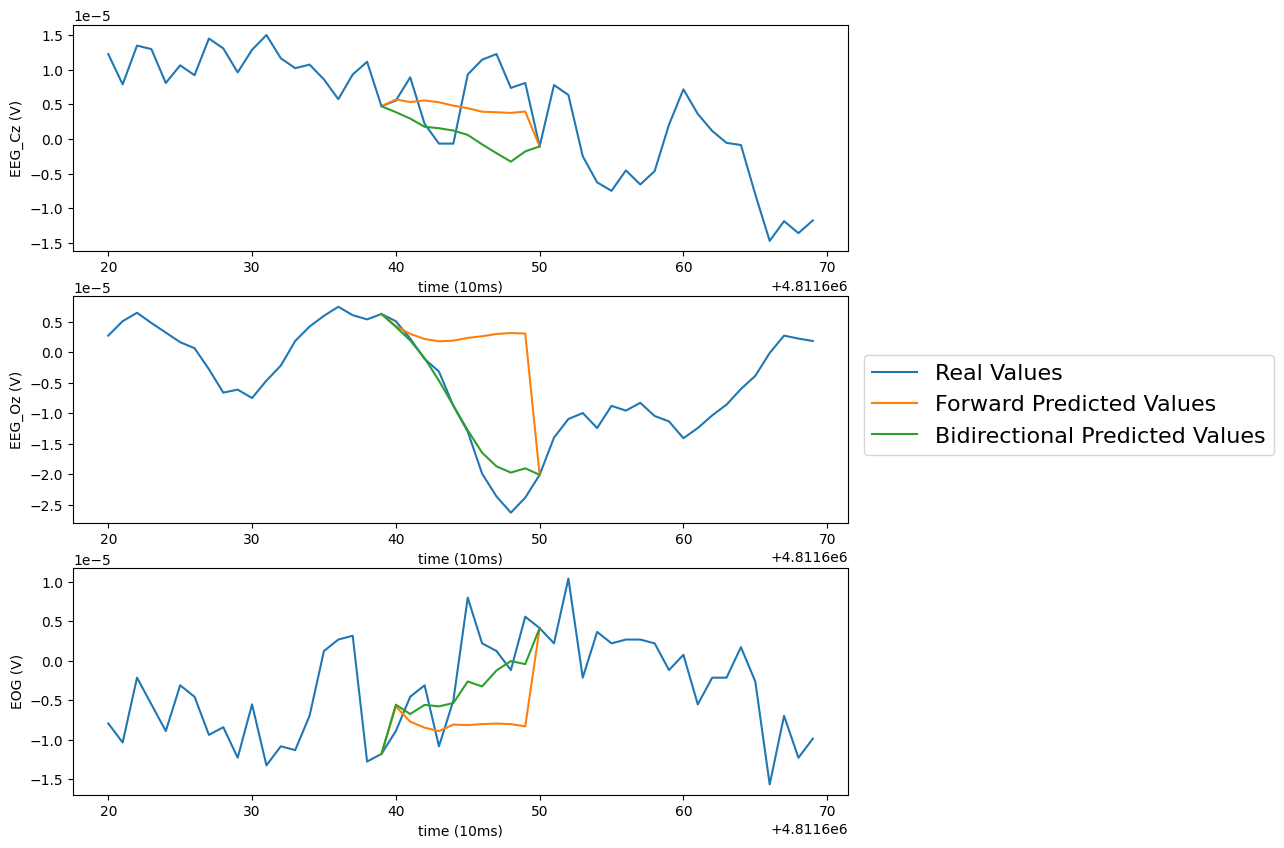

In [52]:
#take a random sample from the data, make sure seed matches other notebook
rng = np.random.default_rng(500)
random_sample = rng.integers(low = 0, high = x_test.shape[0], size = 2)
x_test_sample = x_test[random_sample]

y_test_sample = y_test[random_sample]
y_predict_sample = model.predict(x_test_sample)
#load in forward data
y_predict_sample_forward = np.loadtxt('forward_predict.txt').reshape((2,10,3))
x_test_sample[0] = np.concatenate((scaler.inverse_transform(x_test_sample[0,:,0:3]), scaler.inverse_transform(x_test_sample[0,:,3:6])), axis = 1)
x_test_sample[1] = np.concatenate((scaler.inverse_transform(x_test_sample[1,:,0:3]), scaler.inverse_transform(x_test_sample[1,:,3:6])), axis = 1)
y_test_sample[0] = scaler.inverse_transform(y_test_sample[0])
y_test_sample[1] = scaler.inverse_transform(y_test_sample[1])
y_predict_sample[0] = scaler.inverse_transform(y_predict_sample[0])
y_predict_sample[1] = scaler.inverse_transform(y_predict_sample[1])
y_predict_sample_forward[0] = scaler.inverse_transform(y_predict_sample_forward[0])
y_predict_sample_forward[1] = scaler.inverse_transform(y_predict_sample_forward[1])
#transform data back to original units


fig, ax = plt.subplots(3,1, figsize = (10,10))

#graph data
for i in range(1,x_test_sample.shape[0]):
    t_values_real = range(random_sample[i], random_sample[i] + 50)
    t_values_predicted = t_values_real[19:31]
    eeg_cz_real = np.concatenate((x_test_sample[i,:,0], y_test_sample[i,:,0], x_test_sample[i,:,3]))
    eeg_cz_predicted = np.concatenate((np.array(x_test_sample[i,19,0]).reshape((1,)),y_predict_sample[i,:,0],np.array(x_test_sample[i,0,3]).reshape((1,))))
    eeg_cz_predicted_forward = np.concatenate((np.array(x_test_sample[i,19,0]).reshape((1,)),y_predict_sample_forward[i,:,0],np.array(x_test_sample[i,0,3]).reshape((1,))))
    eeg_oz_real = np.concatenate((x_test_sample[i,:,1], y_test_sample[i,:,1], x_test_sample[i,:,4]))
    eeg_oz_predicted = np.concatenate((np.array(x_test_sample[i,19,1]).reshape((1,)),y_predict_sample[i,:,1],np.array(x_test_sample[i,0,4]).reshape((1,))))
    eeg_oz_predicted_forward = np.concatenate((np.array(x_test_sample[i,19,1]).reshape((1,)),y_predict_sample_forward[i,:,1],np.array(x_test_sample[i,0,4]).reshape((1,))))
    eog_real = np.concatenate((x_test_sample[i,:,2], y_test_sample[i,:,2], x_test_sample[i,:,5]))
    eog_predicted = np.concatenate((np.array(x_test_sample[i,19,2]).reshape((1,)),y_predict_sample[i,:,2],np.array(x_test_sample[i,0,5]).reshape((1,))))
    eog_predicted_forward = np.concatenate((np.array(x_test_sample[i,19,2]).reshape((1,)),y_predict_sample_forward[i,:,2],np.array(x_test_sample[i,0,5]).reshape((1,))))
    ax[0].plot(t_values_real, eeg_cz_real, label = 'Real Values')
    ax[0].plot(t_values_predicted, eeg_cz_predicted_forward, label = 'Forward Predicted Values')
    ax[0].plot(t_values_predicted, eeg_cz_predicted, label = 'Bidirectional Predicted Values')
    ax[1].plot(t_values_real, eeg_oz_real, label = 'Real Values')
    ax[1].plot(t_values_predicted, eeg_oz_predicted_forward, label = 'Forward Predicted Values')
    ax[1].plot(t_values_predicted, eeg_oz_predicted, label = 'Bidirectional Predicted Values')
    ax[2].plot(t_values_real, eog_real, label = 'Real Values')
    ax[2].plot(t_values_predicted, eog_predicted_forward, label = 'Forward Predicted Values')
    ax[2].plot(t_values_predicted, eog_predicted, label = 'Bidirectional Predicted Values')
ax[0].set_xlabel('time (10ms)')
ax[0].set_ylabel('EEG_Cz (V)')
ax[1].set_xlabel('time (10ms)')
ax[1].set_ylabel('EEG_Oz (V)')
ax[2].set_xlabel('time (10ms)')
ax[2].set_ylabel('EOG (V)')

plt.legend(loc=(1.02, 1.5), prop = {'size':16})
fig.savefig('PredictedValues.pdf', bbox_inches = 'tight')
plt.show

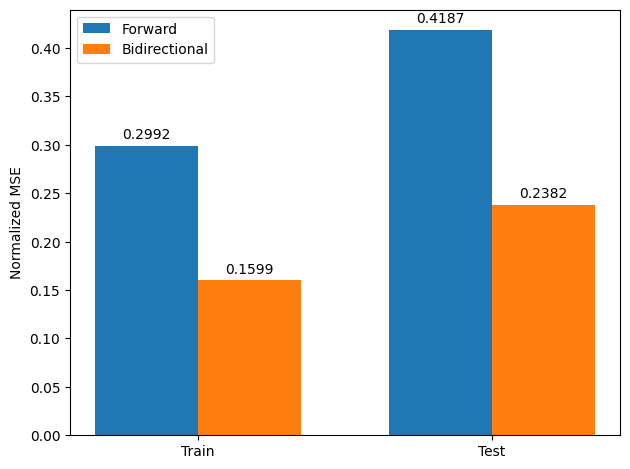

In [71]:
bidirectional_train_mse = 0.1599
bidirectional_test_mse = 0.2382
forward_train_mse = 0.2992
forward_test_mse = 0.4187
labels = ['Train','Test']
forward_mse_values = [0.2992, 0.4187]
bidirectional_mse_values = [0.1599, 0.2382]
x = np.arange(len(labels))
width = 0.35
fig1, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, forward_mse_values, width, label = 'Forward')
rects2 = ax1.bar(x + width/2, bidirectional_mse_values, width, label = 'Bidirectional')
ax1.set_ylabel('Normalized MSE')
ax1.set_xticks(x, labels)
ax1.legend()
ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)

fig1.tight_layout()
fig1.savefig('MSE_barchart.pdf')


plt.show()